### MLS Data Visualization

Last modified: 10/10/2023

In [63]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore", module = "seaborn")

# 3rd party libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Local imports
from mls_stats import Team, league_stats

In [2]:
def round_to_next_five(number: int) -> int:
    return (5 * (round(number/5 +1)))

Forward Passing Accuracy Stripplot (STL v. CIN)

In [3]:
stl = Team('STL', 'St. Louis City SC', 17012, '#ec1458', '#001544', '#fed500')
cin = Team('CIN', 'FC Cincinnati', 11504, '#003087', '#fe5000', '#0b1f41')
stl_df = stl.get_stats()
cin_df = cin.get_stats()
assert (stl_df is not None) and (cin_df is not None)
joint_stats = pd.concat([stl_df.all, cin_df.all], ignore_index=True)

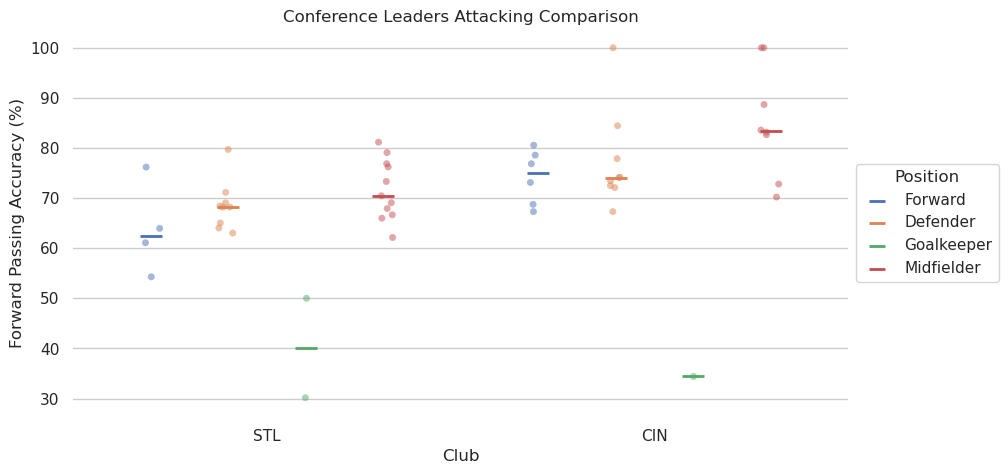

In [4]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(bottom=True, left=True)
sns.stripplot(data=joint_stats, x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic', 
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], alpha=0.50, dodge=True, marker='o', legend=False)
pt_lines = sns.pointplot(data=joint_stats,  x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic',
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], dodge=.6, estimator='median', markers='_', linestyles='none', errorbar=None)

for i in range(8, 12): 
    points = pt_lines.collections[i]
    size= points.get_sizes().item()
    new_sizes=[size*5]
    points.set_sizes(new_sizes)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, title='Position', markerscale=0.75)
ax.set(ylabel='Forward Passing Accuracy (%)', xlabel='Club', title='Conference Leaders Attacking Comparison');

Yellow Cards and Fouls Lost Bivariate Histogram (League)

In [9]:
mls_players = league_stats(2023, 'players')

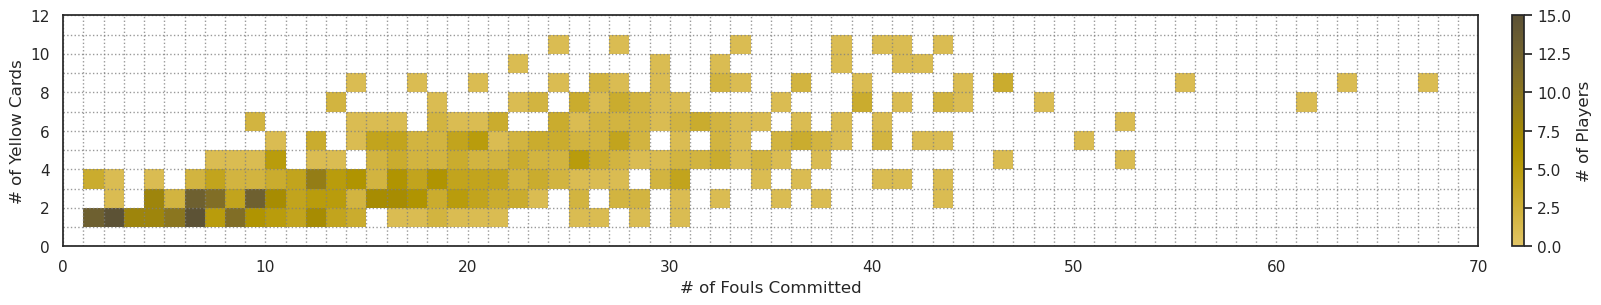

In [111]:
fig, ax = plt.subplots(figsize=(22,3))

sns.set_theme(style='white')
sns.histplot(data=mls_players, x='regular_season_statistics.fk_foul_lost', y='regular_season_statistics.yellow_card', binwidth=1,
             cbar=True, cbar_kws={'label': '# of Players', 'pad': 0.02}, zorder=0, color='gold')
sns.light_palette('goldenrod', as_cmap=True)
ax.set(xlabel='# of Fouls Committed', ylabel='# of Yellow Cards', xlim=(0, 70), ylim=(0, 12))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which='major', color='grey', linestyle=':', alpha=0.8)
ax.grid(which='minor', color='grey', linestyle=':', alpha=0.8)

Goals Pair Grid (League)

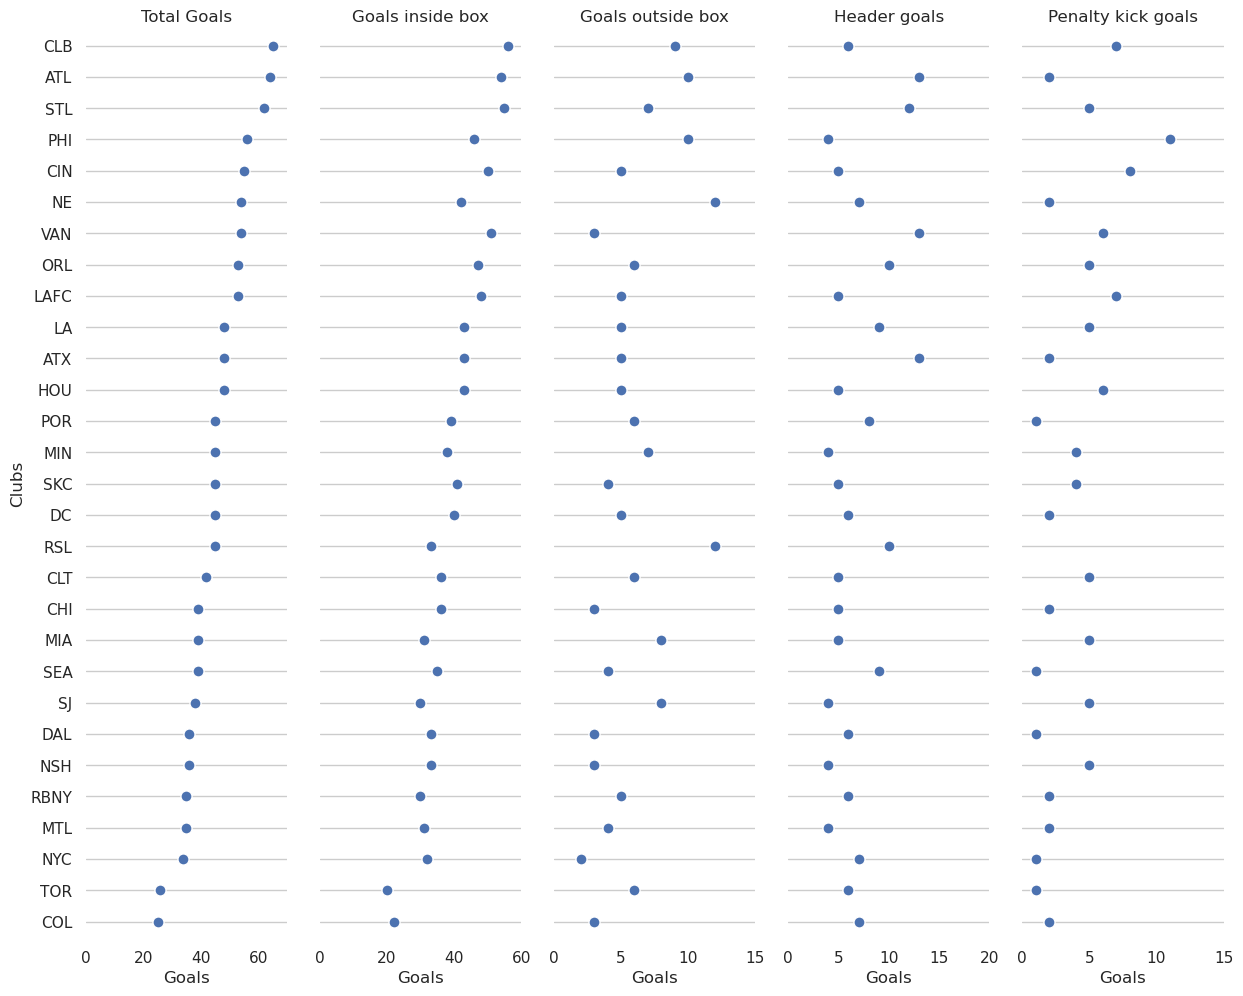

In [11]:
mls_clubs = league_stats(2023, 'clubs')
assert mls_clubs is not None

goal_cols = ['regular_season_statistics.goals', 'regular_season_statistics.att_ibox_goal', 'regular_season_statistics.att_obox_goal', 
             'regular_season_statistics.att_hd_goal', 'regular_season_statistics.att_pen_goal']

g = sns.PairGrid(mls_clubs.sort_values(by='regular_season_statistics.goals', ascending=False),
                 x_vars=goal_cols,
                 y_vars=['club.abbreviation'], height=10, aspect=.25)

g.map(sns.stripplot, size=8, orient='h', jitter=False, palette='flare_r', linewidth=1, edgecolor='w')
g.set(xlabel='Goals', ylabel='Clubs')

titles = ["Total Goals", "Goals inside box", "Goals outside box",
          "Header goals", "Penalty kick goals"]

for i, (ax, title) in enumerate(zip(g.axes.flat, titles)):

    # Set a different title for each axes
    ax.set(title=title, xlim=(0, round_to_next_five(mls_clubs[goal_cols[i]].max())))

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

Win-Draw-Loss Record Since 2000 (SKC)

In [12]:
skc = Team('SKC', 'Sporting Kansas City', 421, '#0c2340', '#a5bad6', '#878b8c')
wins = []
draws = []
losses = []

for i in range(2000, 2023):     # draws were only introduced to rules in 2000
    league_df = league_stats(i, 'clubs')
    assert league_df is not None
    skc_df = league_df[league_df['club.abbreviation'] == 'SKC']
    wins.append(skc_df['regular_season_statistics.total_wins'].loc[skc_df.index[0]])
    draws.append(skc_df['regular_season_statistics.total_draws'].loc[skc_df.index[0]])
    losses.append(skc_df['regular_season_statistics.total_losses'].loc[skc_df.index[0]])

years = np.array(range(2000, 2023))
wdl_stats = {
    'Wins': np.array(wins),
    'Draws': np.array(draws),
    'Losses': np.array(losses),
}

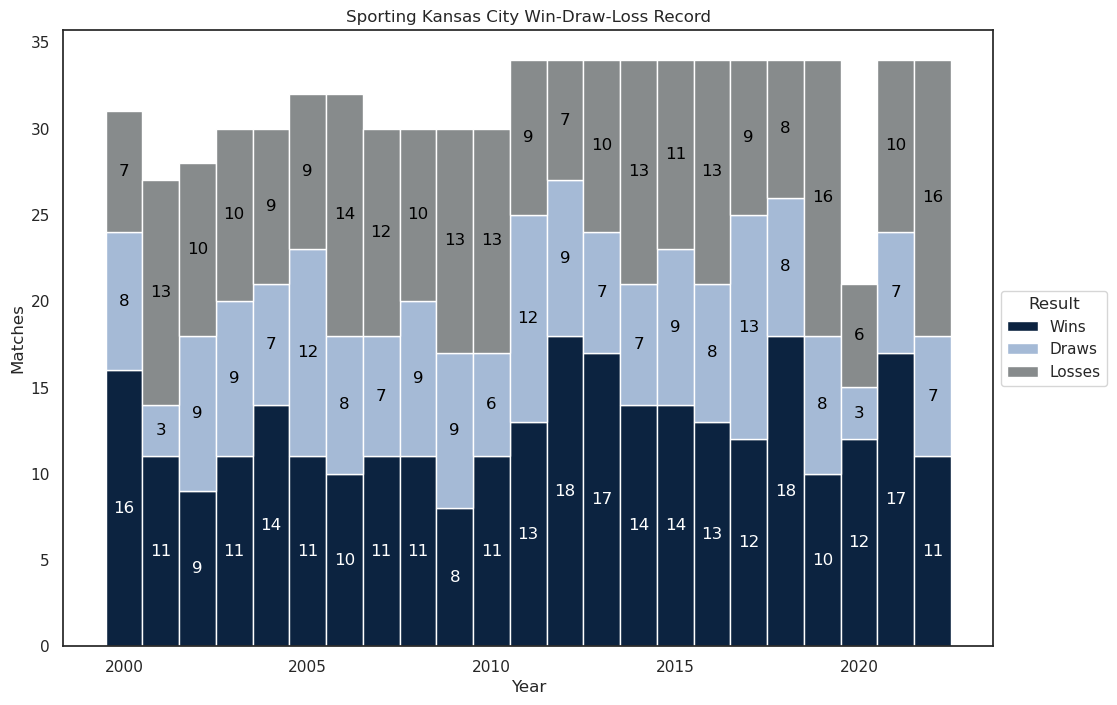

In [15]:
width = 1
bottom = np.zeros(23)

fig, ax = plt.subplots(figsize=(12, 8))
label_cols = ['white', 'black', 'black']
for i, (result, wdl_stat) in enumerate(wdl_stats.items()):
    col_var = f'''skc.color_{i+1}'''
    p = ax.bar(years, wdl_stat, width, label=result, bottom=bottom, color=eval(col_var))
    bottom += wdl_stat

    ax.bar_label(p, label_type='center', color=label_cols[i])

ax.legend(title='Result', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sporting Kansas City Win-Draw-Loss Record', xlabel='Year', ylabel='Matches');

Correlation Matrix Heatmaps

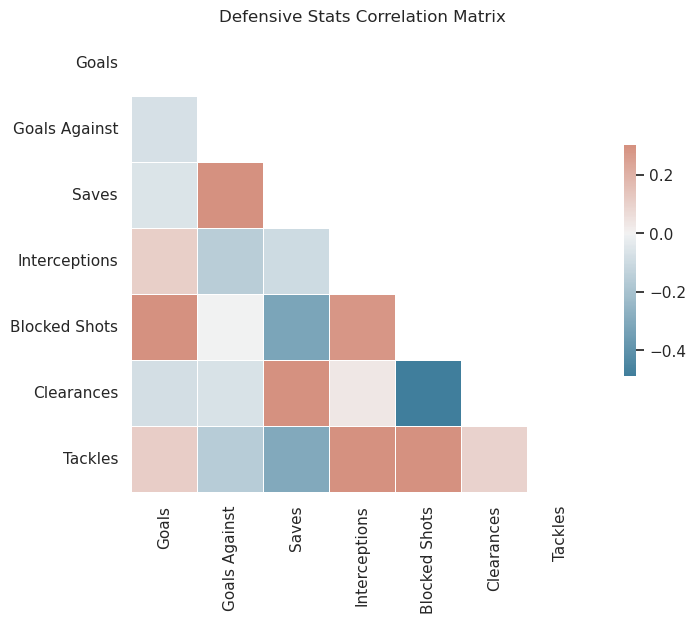

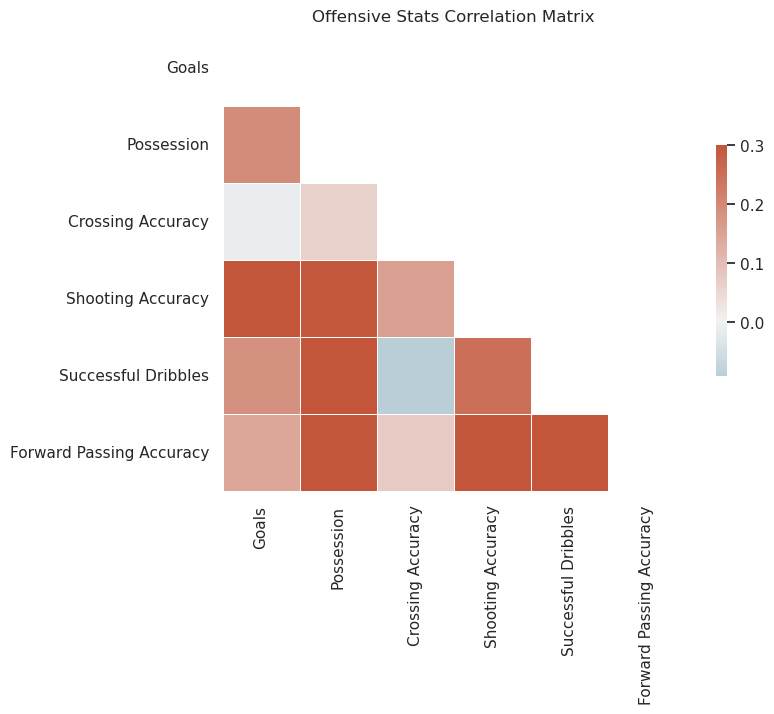

In [25]:
assert mls_clubs is not None

# Make defensive dataframe
defend_df = pd.DataFrame({'Goals': mls_clubs['regular_season_statistics.goals'], 'Goals Against': mls_clubs['regular_season_statistics.goals_conceded'], 'Saves': mls_clubs['regular_season_statistics.saves'], 
                          'Interceptions': mls_clubs['regular_season_statistics.interception'], 'Blocked Shots': mls_clubs['regular_season_statistics.blocked_scoring_att'],
                          'Clearances': mls_clubs['regular_season_statistics.total_clearance'], 'Tackles': mls_clubs['regular_season_statistics.won_tackle']})

# Construct passing/offensive dataframe
attack_df = pd.DataFrame({'Goals': mls_clubs['regular_season_statistics.goals'], 'Possession': mls_clubs['regular_season_statistics.possession_percentage'],
                          'Crossing Accuracy': mls_clubs['regular_season_statistics.accurate_cross_per'], 'Shooting Accuracy': mls_clubs['regular_season_statistics.accurate_shooting_per'], 
                          'Successful Dribbles': mls_clubs['regular_season_statistics.successfull_dribble'], 'Forward Passing Accuracy': mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per']})

# Plot correlation matrices
def_corr = defend_df.corr()
def_mask = np.triu(np.ones_like(def_corr, dtype=bool))
att_corr = attack_df.corr()
att_mask = np.triu(np.ones_like(att_corr, dtype=bool))     # create mask for upper right

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(def_corr, mask=def_mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set(title='Defensive Stats Correlation Matrix');

f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(att_corr, mask=att_mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set(title='Offensive Stats Correlation Matrix');

Linear Regression

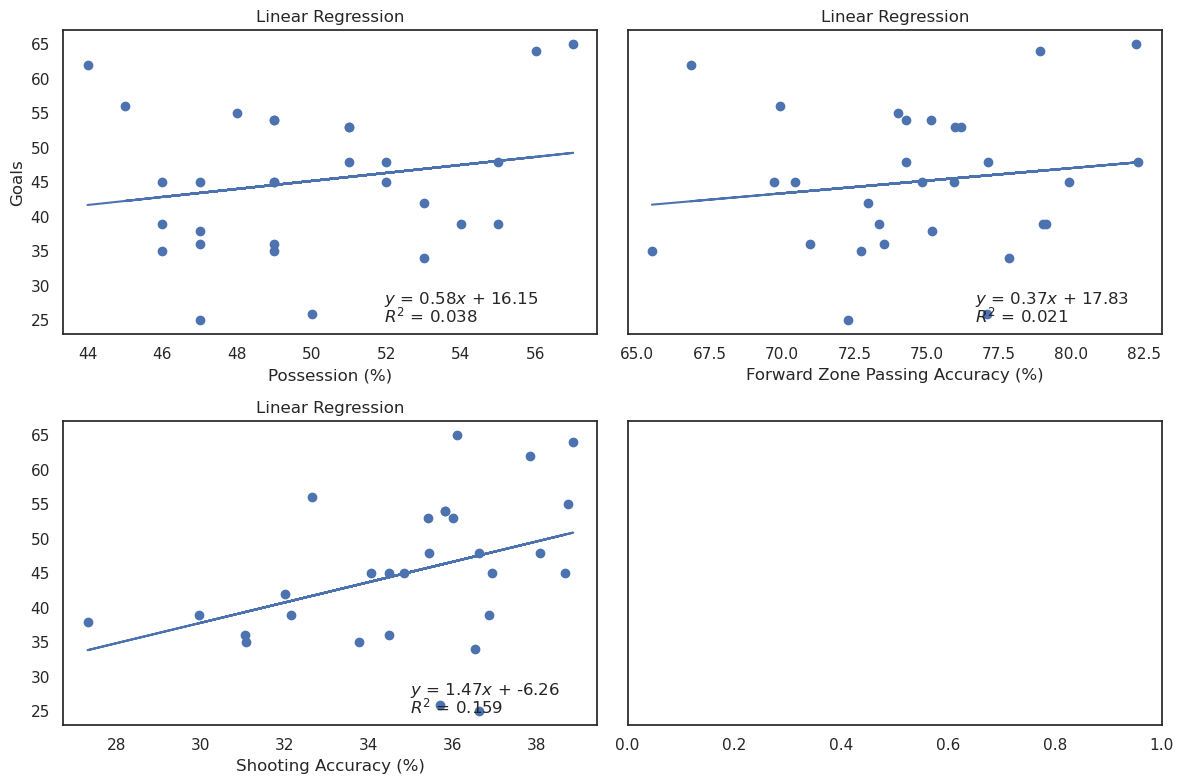

In [17]:
assert mls_clubs is not None
res = stats.linregress(mls_clubs['regular_season_statistics.possession_percentage'], mls_clubs['regular_season_statistics.goals'])
res2 = stats.linregress(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'])
res3 = stats.linregress(mls_clubs['regular_season_statistics.accurate_shooting_per'], mls_clubs['regular_season_statistics.goals'])

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12, 8), tight_layout=True)

# First set
axes[0][0].scatter(mls_clubs['regular_season_statistics.possession_percentage'], mls_clubs['regular_season_statistics.goals'], label='Data')
axes[0][0].plot(mls_clubs['regular_season_statistics.possession_percentage'], (res.intercept + res.slope * mls_clubs['regular_season_statistics.possession_percentage']), label='Fitted Line')
axes[0][0].text(0.6, 0.1, f'''$y$ = {round(res.slope, 2)}$x$ + {round(res.intercept, 2)}''', transform=axes[0][0].transAxes)
axes[0][0].text(0.6, 0.04, f'''$R^2$ = {round(res.rvalue**2, 3)}''', transform=axes[0][0].transAxes)
axes[0][0].set(xlabel='Possession (%)', ylabel='Goals', title='Linear Regression');

# Second set
axes[0][1].scatter(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'], label='Data')
axes[0][1].plot(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], (res2.intercept + res2.slope * mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per']), label='Fitted Line')
axes[0][1].text(0.65, 0.1, f'''$y$ = {round(res2.slope, 2)}$x$ + {round(res2.intercept, 2)}''', transform=axes[0][1].transAxes)
axes[0][1].text(0.65, 0.04, f'''$R^2$ = {round(res2.rvalue**2, 3)}''', transform=axes[0][1].transAxes)
axes[0][1].set(xlabel='Forward Zone Passing Accuracy (%)', title='Linear Regression');

# Third set
axes[1][0].scatter(mls_clubs['regular_season_statistics.accurate_shooting_per'], mls_clubs['regular_season_statistics.goals'], label='Data')
axes[1][0].plot(mls_clubs['regular_season_statistics.accurate_shooting_per'], (res3.intercept + res3.slope * mls_clubs['regular_season_statistics.accurate_shooting_per']), label='Fitted Line')
axes[1][0].text(0.65, 0.1, f'''$y$ = {round(res3.slope, 2)}$x$ + {round(res3.intercept, 2)}''', transform=axes[1][0].transAxes)
axes[1][0].text(0.65, 0.04, f'''$R^2$ = {round(res3.rvalue**2, 3)}''', transform=axes[1][0].transAxes)
axes[1][0].set(xlabel='Shooting Accuracy (%)', title='Linear Regression');